# Matt Ring - Reddit Project

## 1. Load Data

Import relevant packages and data. Subsets data to smaller, more manageable sizes.

### Putting data into your own bucket

In the following cell, you will copy your assigned subreddit from the central teaching bucket to your own persaonl bucket. This cell MUST only be executed once per account!!

In [1]:
#!aws s3 cp s3://bigdatateaching/reddit/subreddits/AskReddit/ s3://mar420-labdata/reddit --recursive

### Reading your entire dataset

In [2]:
import findspark
findspark.init()

In [3]:
import pyspark.sql.functions as f
from pyspark.sql.functions import isnan, when, count, col, lit, desc, mean, expr, countDistinct, dayofweek, hour, to_date, udf
from pyspark.sql import SparkSession
from datetime import datetime
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
spark = SparkSession.builder.appName("reddit").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/30 16:00:09 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
22/04/30 16:00:17 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


Make sure your SparkSession is active:

In [5]:
spark

In [6]:
df_full = spark.read.parquet('s3://mar420-labdata/reddit')

In [7]:
df_full.count()

22/04/30 16:00:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


161464560

### Reading one month worth of data

In [8]:
#!aws s3 ls s3://mar420-labdata/reddit/

In [9]:
# Extract data from June 2021 only
df = spark.read.parquet('s3://mar420-labdata/reddit/ym_partition=202106')

In [10]:
# Assess the number of comments in r/AskReddit during June of 2021
df.count()
# ~6 million comments

6235880

### Developing on a small piece of your data

In [11]:
# Extract 10,000 comments from this month
df_small = df.limit(10000)

In [12]:
# Ensure we got the right number of comments
df_small.count()

10000

In [13]:
# Show the first 5 comments
df_small.show(5)

+-------------+----------------+-------------------+------------------+-----------------------------+----------------------+---------------------+------------------------+-----------------+-----------------------+-----------------+---------------+--------------------+--------------+--------+--------------------+--------+------------+---------+-------------------------------+----------------+------------+----------------+-----------+-------------+------+------+--------+-------+------------+---------+------+---------+----------+--------------------+-----------+--------------+------------+-----+------------+--------+------------+-----------------------+--------------+----------------+---------------------+--------------+--------------+--------+--------------+
|all_awardings|associated_award|             author|author_created_utc|author_flair_background_color|author_flair_css_class|author_flair_richtext|author_flair_template_id|author_flair_text|author_flair_text_color|author_flair_type|au

## 2. Cleaning & Exploration

Explore the types and distriutions of each feature, then clean accordingly.

### Feature Types
Simply prints the feature type of each column in the dataset.

In [14]:
# Assess the features in these data
df.printSchema()

root
 |-- all_awardings: string (nullable = true)
 |-- associated_award: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_created_utc: double (nullable = true)
 |-- author_flair_background_color: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_richtext: string (nullable = true)
 |-- author_flair_template_id: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_text_color: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: boolean (nullable = true)
 |-- author_premium: boolean (nullable = true)
 |-- awarders: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- can_mod_post: boolean (nullable = true)
 |-- collapsed: boolean (nullable = true)
 |-- collapsed_because_crowd_control: string (nullable = true)
 |-- collapsed_reason: 

### Missing Data

Checks for initial missing data. Fills in missing data where missing values represent something important. Removes other columns with too much missing data (e.g. 90%+ of data missing).

In [15]:
# Separate non-boolean and boolean variables
data_type = dict(df.dtypes)
keys = list(data_type.keys())
vals = list(data_type.values())
booleans = [l  == "boolean" for l in vals]
non_bool = [l  != "boolean" for l in vals]
non_bool_cols = [keys[i] for i in range(len(keys)) if non_bool[i]]
bool_cols = [keys[i] for i in range(len(keys)) if booleans[i]]

In [16]:
# Check the number of missing features per non-boolean column
df_small.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in non_bool_cols]).show()

+-------------+----------------+------+------------------+-----------------------------+----------------------+---------------------+------------------------+-----------------+-----------------------+-----------------+---------------+--------+----+-------------------------------+----------------+------------+----------------+-----------+-------------+------+------+--------+---+-------+---------+---------+--------------+------------+-----+------------+-----------------------+--------------+----------------+---------------------+--------------+--------------+
|all_awardings|associated_award|author|author_created_utc|author_flair_background_color|author_flair_css_class|author_flair_richtext|author_flair_template_id|author_flair_text|author_flair_text_color|author_flair_type|author_fullname|awarders|body|collapsed_because_crowd_control|collapsed_reason|comment_type|controversiality|created_utc|distinguished|edited|gilded|gildings| id|link_id|parent_id|permalink|removal_reason|retrieved_on|

Non-boolean columns missing 90% or more of their values for this month are as follows:
1. author_flair_background_color
2. author_flair_css_class
2. author_flair_template_id
3. author_flair_text
4. author_flair_text_color
4. awarders
5. collapsed_because_crowd_control
5. collapsed_reason
6. comment_type
6. distinguished
7. edited
7. removal_reason
8. retrieved_on
9. subreddit_name_prefixed
10. top_awarded_type
11. media_metadata

In [17]:
# Repeat the above after removing columns with no data
no_data_cols = ["author_flair_background_color", "author_flair_css_class", "author_flair_template_id",
                "author_flair_text", "author_flair_text_color", "awarders", "collapsed_because_crowd_control",
                "collapsed_reason", "comment_type", "removal_reason", "retrieved_on", "subreddit_name_prefixed",
                "distinguished", "edited", "top_awarded_type", "media_metadata"]
non_bool_cols_v2 = [c for c in non_bool_cols if c not in no_data_cols]
df_small.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in non_bool_cols_v2]).show()

+-------------+----------------+------+------------------+---------------------+-----------------+---------------+----+----------------+-----------+------+--------+---+-------+---------+---------+-----+------------+--------------+---------------------+--------------+
|all_awardings|associated_award|author|author_created_utc|author_flair_richtext|author_flair_type|author_fullname|body|controversiality|created_utc|gilded|gildings| id|link_id|parent_id|permalink|score|subreddit_id|subreddit_type|total_awards_received|treatment_tags|
+-------------+----------------+------+------------------+---------------------+-----------------+---------------+----+----------------+-----------+------+--------+---+-------+---------+---------+-----+------------+--------------+---------------------+--------------+
|            0|               0|     0|               845|                  845|              845|            845|   0|               0|          0|     0|       0|  0|      0|        0|        0|

In [18]:
# Check if the "distinguished" category has an obvious replacement for missing values
df_small.groupby('distinguished').count().collect()

[Row(distinguished='moderator', count=171),
 Row(distinguished=None, count=9829)]

In [19]:
# Check if the "edited" category has an obvious replacement for missing values
#df_small.groupby('edited').count().collect()

After some review, it appears the `edited` variable has no discernable rationale, with each value being unique. The `distinguished` category means that a comment was visibly flagged as posted by a moderator. Thus, missing values here have meaning and will be replaced with "non-distinguished".

In [20]:
# Replace missing values in the "distinguished" category
df_small = df_small.na.fill(value="non_distinguished",subset=["distinguished"])
df = df.na.fill(value="non_distinguished",subset=["distinguished"])
df_full = df_full.na.fill(value="non_distinguished",subset=["distinguished"])

In [21]:
# Create a list of rows missing 90%+ of their data
non_bool_cols_v2.append("distinguished")
to_drop = [c for c in keys if (c not in bool_cols) & (c not in non_bool_cols_v2)]

In [22]:
# Drop rows missing at least 90% of their values
df_small = df_small.drop(*to_drop)
df = df.drop(*to_drop)
df_full = df_full.drop(*to_drop)

In [23]:
# Save intermediate data
df_full.write.format('csv').option('header','true').save("s3://mar420-labdata/df_full_rm_sparse_cols", mode="overwrite")

### Categorical Feature Counts

Assesses distributions in categorical features. Subsets to only those with meaningful and useful infromation. Removes those without enough data, too imbalanced, or unknown meaning.

In [24]:
# Check the counts for values of all awardings
df_small.groupBy('all_awardings').count().select(f.col("all_awardings").alias("all_awardings"),f.col("count").alias("instances")).sort(desc("count")).show()

+--------------------+---------+
|       all_awardings|instances|
+--------------------+---------+
|                  []|     9972|
|[{'award_sub_type...|        5|
|[{'award_sub_type...|        4|
|[{'award_sub_type...|        4|
|[{'award_sub_type...|        2|
|[{'award_sub_type...|        2|
|[{'award_sub_type...|        1|
|[{'award_sub_type...|        1|
|[{'award_sub_type...|        1|
|[{'award_sub_type...|        1|
|[{'award_sub_type...|        1|
|[{'award_sub_type...|        1|
|[{'award_sub_type...|        1|
|[{'award_sub_type...|        1|
|[{'award_sub_type...|        1|
|[{'award_sub_type...|        1|
|[{'award_sub_type...|        1|
+--------------------+---------+



To see exactly what `all_awardings` shows, one can run this code: df.groupby('all_awardings').count().collect().

The content of this feature is strange and uninformative, the `associated_award` variable likely has more succinct and useful information. The vast majority of values here are empty lists.

In [25]:
# Check the counts for values of associated award
df_small.groupBy('associated_award').count().select(f.col("associated_award").alias("associated_award"),f.col("count").alias("instances")).sort(desc("count")).show()

+----------------+---------+
|associated_award|instances|
+----------------+---------+
|            None|    10000|
+----------------+---------+



Associated award appears not to have any useful data for this small dataset, with all values being ***None***. There is data on "total awards received" later, so this will be removed.

In [26]:
# Check the counts for values of author
df_small.groupBy('author').count().select(f.col("author").alias("author"),f.col("count").alias("instances")).sort(desc("count")).show()

+--------------------+---------+
|              author|instances|
+--------------------+---------+
|           [deleted]|      836|
|       AutoModerator|      142|
|         I_am_a_mask|       36|
|         Thecanman07|       36|
|        Domesticgay_|       28|
|    billybobjimmyjoe|       22|
|7sagesotebamboogrove|       22|
|           ZedLyfe51|       20|
|             shnougz|       19|
|         bruteski226|       19|
|    dukedepommefrite|       19|
|     Viva_La_Ravioli|       19|
|       Regime-leader|       19|
|           JetLife93|       19|
|      AmbiguousAxiom|       19|
|           BlaccSage|       18|
|         Bluuryfaace|       17|
|    TheBrokhanReaper|       17|
|             nekurra|       17|
|    Inner_Cress_6478|       16|
+--------------------+---------+
only showing top 20 rows



`author` could prove useful, as we see a variety of usernames. Note that some of these values are ***[deleted]*** and may need to be cleaned up. That said, `author_fullname` contains the immutable, unique versions of usernames.

In [27]:
# Check the counts for values of author flair richtext
df_small.groupBy('author_flair_richtext').count().select(f.col("author_flair_richtext").alias("author_flair_richtext"),f.col("count").alias("instances")).sort(desc("count")).show()

+---------------------+---------+
|author_flair_richtext|instances|
+---------------------+---------+
|                   []|     9014|
|                  nan|      986|
+---------------------+---------+



This subset of the author flair variable seems particularly useless, with most values being empty lists or nan.

In [28]:
# Replace missing values in the "flair type" category with "no_flair"
df_small = df_small.na.fill(value="no_flair",subset=["author_flair_type"])
df = df.na.fill(value="no_flair",subset=["author_flair_type"])
df_full = df_full.na.fill(value="no_flair",subset=["author_flair_type"])

# Check the counts for values of author flair type
df_small.groupBy('author_flair_type').count().select(f.col("author_flair_type").alias("author_flair_type"),f.col("count").alias("instances")).sort(desc("count")).show()

+-----------------+---------+
|author_flair_type|instances|
+-----------------+---------+
|             text|     9164|
|         no_flair|      836|
+-----------------+---------+



Perhaps this could be useful, as `author_flair_type` tells us which comments are made by users with flairs. Users with flairs are likely the most active on a site.

In [29]:
# Check the counts for values of author full name
df_small.groupBy('author_fullname').count().select(f.col("author_fullname").alias("author_fullname"),f.col("count").alias("instances")).sort(desc("count")).show()

+---------------+---------+
|author_fullname|instances|
+---------------+---------+
|           null|      836|
|       t2_6l4z3|      142|
|    t2_86tzb1l5|       36|
|    t2_3j48ubnr|       36|
|    t2_7onn30gn|       28|
|       t2_y44xx|       22|
|    t2_4ydmjn9p|       22|
|    t2_68s86ieu|       20|
|    t2_3zdqn9nq|       19|
|       t2_x3jqu|       19|
|    t2_4780tu12|       19|
|    t2_640kx40n|       19|
|    t2_6yxg6bcc|       19|
|       t2_675fa|       19|
|    t2_92suklc4|       19|
|    t2_77fmuqpj|       18|
|    t2_4rzotzy2|       17|
|     t2_xb26web|       17|
|    t2_b9zwg7fm|       17|
|    t2_896kjbrq|       16|
+---------------+---------+
only showing top 20 rows



The information here is the unique, immutable ID for an `author`. Will be kept.

In [30]:
# Check the counts for values of body
df_small.groupBy('body').count().select(f.col("body").alias("body"),f.col("count").alias("instances")).sort(desc("count")).show()

+--------------------+---------+
|                body|instances|
+--------------------+---------+
|           [deleted]|      488|
|           [removed]|      234|
|**PLEASE READ THI...|       42|
|**PLEASE READ THI...|       32|
|**PLEASE READ THI...|       17|
|**Attention! [Ser...|       14|
|Was it both your ...|        8|
|                Same|        7|
|This submission h...|        7|
|                Nice|        5|
|     Happy cake day!|        4|
|**PLEASE READ THI...|        4|
|      Oddly specific|        3|
|This submission h...|        3|
|               Shrek|        3|
|               What?|        3|
|              Ignore|        3|
|                  Me|        3|
|      Apple products|        3|
|               Same.|        3|
+--------------------+---------+
only showing top 20 rows



These look to contain the body of text. Many appear to be deleted, removed, or moderator updates in bold. Some of the most common comments are simple. "Shrek" also appears here. This will be kept.

In [31]:
# Check the counts for values of gildings
df_small.groupBy('gildings').count().select(f.col("gildings").alias("gildings"),f.col("count").alias("instances")).sort(desc("count")).show()

+------------+---------+
|    gildings|instances|
+------------+---------+
|          {}|     9991|
|{'gid_1': 1}|        7|
|{'gid_2': 1}|        2|
+------------+---------+



An incredibly sparse variable, this contains only 14 non-empty dictionaries. Gildings tells something about Reddit Gold, the paid version of Reddit. This may be useful, but there is a binary variable which tells whether one is gilded that should be used as it is more interpretable.

In [32]:
# Check the counts for values of id
df_small.groupBy('id').count().select(f.col("id").alias("id"),f.col("count").alias("instances")).sort(desc("count")).show()

+-------+---------+
|     id|instances|
+-------+---------+
|h05o9uf|        1|
|h05o9uq|        1|
|h05o9ve|        1|
|h05o9wq|        1|
|h05o9xw|        1|
|h05o9xy|        1|
|h05o9yh|        1|
|h05oa1h|        1|
|h05oa2y|        1|
|h05oa3c|        1|
|h05oa4r|        1|
|h05oa5j|        1|
|h05oa5l|        1|
|h05oa8p|        1|
|h05oa8y|        1|
|h05oa90|        1|
|h05oa9a|        1|
|h05oaa0|        1|
|h05oaa9|        1|
|h05oaaq|        1|
+-------+---------+
only showing top 20 rows



This appears to uniquely idenfity comments. Will be kept.

In [33]:
# Check the counts for values of submission link id
df_small.groupBy('link_id').count().select(f.col("link_id").alias("link_id"),f.col("count").alias("instances")).sort(desc("count")).show()

+---------+---------+
|  link_id|instances|
+---------+---------+
|t3_nql6xv|     1743|
|t3_nqpuda|      314|
|t3_nqkh7n|      266|
|t3_nqjyhq|      184|
|t3_nqjxe8|      184|
|t3_o633y0|      182|
|t3_nqks49|      166|
|t3_o65mi1|      147|
|t3_nq9fjc|      127|
|t3_nqzts4|      127|
|t3_nqu2nt|       96|
|t3_nqp7l2|       87|
|t3_nqzzc1|       78|
|t3_o6446e|       72|
|t3_nqvazw|       71|
|t3_nql2zg|       61|
|t3_nqk3y7|       50|
|t3_nqqngt|       45|
|t3_nqq1jp|       44|
|t3_nqy6dq|       42|
+---------+---------+
only showing top 20 rows



In [34]:
# Check the counts for values of parent comment id
df_small.groupBy('parent_id').count().select(f.col("parent_id").alias("parent_id"),f.col("count").alias("instances")).sort(desc("count")).show()

+----------+---------+
| parent_id|instances|
+----------+---------+
| t3_o5jepd|      983|
| t3_o5n00e|      734|
| t3_o5mpk2|      310|
| t3_o5lyoh|       89|
| t3_o5wb8n|       68|
| t3_o5wlse|       53|
| t3_o5pkfr|       47|
| t3_o5d4n8|       46|
|t1_h2oboft|       43|
| t3_o5m1vh|       38|
| t3_o5l2gb|       34|
| t3_o5n9s0|       34|
| t3_o5wqga|       32|
| t3_o5dmyj|       31|
| t3_o5b2ku|       29|
| t3_o5wrps|       29|
| t3_o5vc3q|       28|
| t3_o4tzin|       25|
| t3_o5ajpu|       24|
| t3_o5wiry|       23|
+----------+---------+
only showing top 20 rows



Based on comments here: https://www.reddit.com/r/pushshift/comments/u7bvu8/having_some_trouble_with_parent_ids_and_link_ids/

`link_id` is the id for a particular submission and `parent_id` is the id for a comment one has replied to OR the submission. We could use this to find highly commented submissions, comment vs. score ratios, and long conversations.

In [35]:
# Check the counts for values of permalink
df_small.groupBy('permalink').count().select(f.col("permalink").alias("permalink"),f.col("count").alias("instances")).sort(desc("count")).show()

+--------------------+---------+
|           permalink|instances|
+--------------------+---------+
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
|/r/AskReddit/comm...|        1|
+--------------------+---------+
only showing top 20 rows



Gives the link to the particular comment. Not necessarily useful.

In [36]:
# Check the counts for values of id
df_small.groupBy('subreddit_id').count().select(f.col("subreddit_id").alias("subreddit_id"),f.col("count").alias("instances")).sort(desc("count")).show()

+------------+---------+
|subreddit_id|instances|
+------------+---------+
|    t5_2qh1i|    10000|
+------------+---------+



In [37]:
# Check the counts for values of id
df.groupBy('subreddit_type').count().select(f.col("subreddit_type").alias("subreddit_type"),f.col("count").alias("instances")).sort(desc("count")).show()

+--------------+---------+
|subreddit_type|instances|
+--------------+---------+
|        public|  6235880|
+--------------+---------+



Information about the subreddit. As our project focuses on a single subreddit (e.g. AskReddit), these features are of no use.

In [38]:
# Check the counts for values of id
df_small.groupBy('treatment_tags').count().select(f.col("treatment_tags").alias("treatment_tags"),f.col("count").alias("instances")).sort(desc("count")).show()

+--------------------+---------+
|      treatment_tags|instances|
+--------------------+---------+
|                  []|     9999|
|['econ:render:lot...|        1|
+--------------------+---------+



A feature containing only empty lists with no obvious use based on the name. Will be removed.

In [39]:
# Drop unnecessary categorical columns
to_drop = ["associated_award", "all_awardings", "author_flair_richtext", 
           "author", "permalink", "subreddit_id", "subreddit_type", "gildings", "treatment_tags"]
df_small = df_small.drop(*to_drop)
df = df.drop(*to_drop)
df_full = df_full.drop(*to_drop)

### Binary Feature Counts

Assesses distributions in boolean features. Subsets to only those with meaningful and useful infromation. Removes those without enough data, too imbalanced, or unknown meaning.

In [40]:
# Finding boolean features
bool_cols

['author_patreon_flair',
 'author_premium',
 'can_gild',
 'can_mod_post',
 'collapsed',
 'is_submitter',
 'locked',
 'no_follow',
 'quarantined',
 'send_replies',
 'stickied',
 'author_cakeday',
 'editable']

In [41]:
# Check the counts for values of the authors patreon flair
df_small.groupBy('author_patreon_flair').count().select(f.col("author_patreon_flair").alias("author_patreon_flair"),f.col("count").alias("instances")).sort(desc("count")).show()

+--------------------+---------+
|author_patreon_flair|instances|
+--------------------+---------+
|               false|     9089|
|                null|      911|
+--------------------+---------+



The above shows all falses and nulls. I'm not certain what this entails, but it doesn't match with the categorical flairs text variable. Can be dropped.

In [42]:
# Check the counts for values of whether an author is premium
df_small.groupBy('author_premium').count().select(f.col("author_premium").alias("author_premium"),f.col("count").alias("instances")).sort(desc("count")).show()

+--------------+---------+
|author_premium|instances|
+--------------+---------+
|         false|     8683|
|          null|      845|
|          true|      472|
+--------------+---------+



In [43]:
# Check the counts for values of whether a comment can be guilded?
df_small.groupBy('can_gild').count().select(f.col("can_gild").alias("can_gild"),f.col("count").alias("instances")).sort(desc("count")).show()

+--------+---------+
|can_gild|instances|
+--------+---------+
|    true|     9719|
|   false|      281|
+--------+---------+



In [44]:
# Check the counts for values of whether a commenter can post as a moderator
df_small.groupBy('can_mod_post').count().select(f.col("can_mod_post").alias("can_mod_post"),f.col("count").alias("instances")).sort(desc("count")).show()

+------------+---------+
|can_mod_post|instances|
+------------+---------+
|       false|    10000|
+------------+---------+



In [45]:
# Check the counts for values of whether a commenter can post as a moderator
df_small.groupBy('collapsed').count().select(f.col("collapsed").alias("collapsed"),f.col("count").alias("instances")).sort(desc("count")).show()

+---------+---------+
|collapsed|instances|
+---------+---------+
|    false|     9279|
|     true|      721|
+---------+---------+



The above checks whether a comment was "collapsed" or not. It could be interesting to see the effect of a comments visibility on score, subcomments, etc.

In [46]:
# Check the counts for values of whether a commenter is the original poster
df_small.groupBy('is_submitter').count().select(f.col("is_submitter").alias("is_submitter"),f.col("count").alias("instances")).sort(desc("count")).show()

+------------+---------+
|is_submitter|instances|
+------------+---------+
|       false|     9643|
|        true|      357|
+------------+---------+



There are usually flairs showing this as well, we'll keep this in as it's important for the culture of Reddit.

In [47]:
# Check the counts for values of whether a comment is locked
df_small.groupBy('locked').count().select(f.col("locked").alias("locked"),f.col("count").alias("instances")).sort(desc("count")).show()

+------+---------+
|locked|instances|
+------+---------+
| false|     9984|
|  true|       16|
+------+---------+



In [48]:
# Check the counts for values of whether a comment is NOT being followed by anyone
df_small.groupBy('no_follow').count().select(f.col("no_follow").alias("no_follow"),f.col("count").alias("instances")).sort(desc("count")).show()

+---------+---------+
|no_follow|instances|
+---------+---------+
|     true|     7358|
|    false|     2642|
+---------+---------+



Checks whether people are following a comment, seems very useful and is a common button on Reddit. Should increase engagement, right?

In [49]:
# Check the counts for values of whether a comment is quarantined
df_small.groupBy('quarantined').count().select(f.col("quarantined").alias("quarantined"),f.col("count").alias("instances")).sort(desc("count")).show()

+-----------+---------+
|quarantined|instances|
+-----------+---------+
|      false|    10000|
+-----------+---------+



In [50]:
# Check the counts for values of whether a comment has been "stuck" to the top of a subreddit by mods
df_small.groupBy('stickied').count().select(f.col("stickied").alias("stickied"),f.col("count").alias("instances")).sort(desc("count")).show()

+--------+---------+
|stickied|instances|
+--------+---------+
|   false|     9986|
|    true|       14|
+--------+---------+



In [51]:
# Check the counts for values of whether a comment was posted on the author's reddit anniversary
df_small.groupBy('author_cakeday').count().select(f.col("author_cakeday").alias("author_cakeday"),f.col("count").alias("instances")).sort(desc("count")).show()

+--------------+---------+
|author_cakeday|instances|
+--------------+---------+
|          null|     9939|
|          true|       61|
+--------------+---------+



In [52]:
# Check the counts for values of whether a comment is editable
df_small.groupBy('editable').count().select(f.col("editable").alias("editable"),f.col("count").alias("instances")).sort(desc("count")).show()

+--------+---------+
|editable|instances|
+--------+---------+
|    null|    10000|
+--------+---------+



In [53]:
# Drop unnecessary binary columns
to_drop = ["author_patreon_flair", "author_premium", "can_gild", "can_mod_post", "locked", "quarantined", 'send_replies', "stickied", "author_cakeday", "editable"]
df_small = df_small.drop(*to_drop)
df = df.drop(*to_drop)
df_full = df_full.drop(*to_drop)

### Continuous Feature Summaries

Assesses distributions in continuous features. Subsets to only those with meaningful and useful infromation. Removes those without enough data, too imbalanced, or unknown meaning.

In [54]:
# author_created_utc: Average, median, Q25, and Q75 fare amount alongside counts per group
df_small.agg(mean("author_created_utc").alias("mean_utc_created"), 
       expr('percentile(author_created_utc, array(0.25))')[0].alias('Q25'),
       expr('percentile(author_created_utc, array(0.5))')[0].alias('median'),
       expr('percentile(author_created_utc, array(0.75))')[0].alias('Q75'),
       count("author_created_utc").alias("count")).show(10)

+--------------------+-----------+-------------+-------------+-----+
|    mean_utc_created|        Q25|       median|          Q75|count|
+--------------------+-----------+-------------+-------------+-----+
|1.5329766589588513E9|1.4839116E9|1.569412045E9|1.606630406E9| 9089|
+--------------------+-----------+-------------+-------------+-----+



This feature may show when an author's account was created. Upon further inspection, nearly 10% of the data was missing. We'll keep this feature and remove rows missing this value as it would be awesome to investigate the relationship between time on reddit and post interactions.

In [55]:
# created_utc: Average, median, Q25, and Q75 fare amount alongside counts per group
df_small.agg(mean("created_utc").alias("created_utc"), 
       expr('percentile(created_utc, array(0.25))')[0].alias('Q25'),
       expr('percentile(created_utc, array(0.5))')[0].alias('median'),
       expr('percentile(created_utc, array(0.75))')[0].alias('Q75'),
       count("created_utc").alias("count")).show(10)

+-----------------+-------------+-------------+-------------+-----+
|      created_utc|          Q25|       median|          Q75|count|
+-----------------+-------------+-------------+-------------+-----+
|1.6243952065593E9|1.624394447E9|1.624395192E9|1.624395976E9|10000|
+-----------------+-------------+-------------+-------------+-----+



The above feature show when a comment was created. We will keep this.

In [56]:
# Whether a comment has as many downvotes as upvotes, indicated by a dagger symbol on Reddit
df_small.groupBy('controversiality').count().select(f.col("controversiality").alias("controversiality"),f.col("count").alias("instances")).sort(desc("count")).show()

+----------------+---------+
|controversiality|instances|
+----------------+---------+
|               0|     9885|
|               1|      115|
+----------------+---------+



The above is technically a binary, per this: https://www.reddit.com/r/redditdev/comments/5bekuz/what_is_the_controversiality_value_used_for_when/

Its job is "indicating whether or not a comment has received a similar amount of upvotes to downvotes, hence being controversial." We'll keep it.

In [57]:
# Whether a comment earned the commenter reddit gold
df_small.groupBy('gilded').count().select(f.col("gilded").alias("gilded"),f.col("count").alias("instances")).sort(desc("count")).show()

+------+---------+
|gilded|instances|
+------+---------+
|     0|     9998|
|     1|        1|
|     2|        1|
+------+---------+



Tells whether the original poster was gilded, i.e. how man months of Reddit Gold they received. Is incredibly imbalanced, but we'll keep it for now.

In [58]:
# total_awards_received: Average, median, Q25, and Q75 fare amount alongside counts per group
df_small.agg(mean("total_awards_received").alias("mean_awards"),
       f.min("total_awards_received").alias('min'),
       expr('percentile(total_awards_received, array(0.25))')[0].alias('Q25'),
       expr('percentile(total_awards_received, array(0.5))')[0].alias('median'),
       expr('percentile(total_awards_received, array(0.75))')[0].alias('Q75'),
       f.max("total_awards_received").alias('max'),
       count("total_awards_received").alias("count")).show(10)

+-----------+---+---+------+---+---+-----+
|mean_awards|min|Q25|median|Q75|max|count|
+-----------+---+---+------+---+---+-----+
|     0.0127|  0|0.0|   0.0|0.0| 32|10000|
+-----------+---+---+------+---+---+-----+



In [59]:
# author_created_utc: Average, median, Q25, and Q75 fare amount alongside counts per group
df_small.agg(mean("score").alias("mean_score"),
       f.min("score").alias('min'),
       expr('percentile(score, array(0.25))')[0].alias('Q25'),
       expr('percentile(score, array(0.5))')[0].alias('median'),
       expr('percentile(score, array(0.75))')[0].alias('Q75'),
       f.max("score").alias('max'),
       count("score").alias("count")).show(10)

+----------+---+---+------+---+-----+-----+
|mean_score|min|Q25|median|Q75|  max|count|
+----------+---+---+------+---+-----+-----+
|   23.4608|-80|1.0|   1.0|2.0|22422|10000|
+----------+---+---+------+---+-----+-----+



Quite possibly the most important variable here, this represents the score for a particular comment, as a sum of upvotes and downvotes.

### Filtering

Recheck for remaining nulls and remove rows with nulls this time.

In [60]:
# Check the number of missing features one more time
df_small.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns if (c not in bool_cols)]).show()

+------------------+-----------------+---------------+----+----------------+-----------+-------------+------+---+-------+---------+-----+---------------------+
|author_created_utc|author_flair_type|author_fullname|body|controversiality|created_utc|distinguished|gilded| id|link_id|parent_id|score|total_awards_received|
+------------------+-----------------+---------------+----+----------------+-----------+-------------+------+---+-------+---------+-----+---------------------+
|               836|                0|            836|   0|               0|          0|            0|     0|  0|      0|        0|    0|                    0|
+------------------+-----------------+---------------+----+----------------+-----------+-------------+------+---+-------+---------+-----+---------------------+



There are a few nulls in the `author_created_utc` and `author_fullname` features, likely where a comment was deleted. Let's remove those.

In [61]:
# Keep only rows/instances/observations not missing any data
df_small = df_small.na.drop(how="any")
df = df.na.drop(how="any")
df_full = df_full.na.drop(how="any")

### Other Feature Engineering

Create new features or adjust feature types as needed. Currently modifies timestamp data, adds a feature of how long a user was on Reddit prior to this comment, and add comment length.

In [62]:
# Change the time variables to be datetimes
# Add a variable for how long the author has been on Reddit in days (Decimal is used to convert from seconds to days)
df_small = df_small \
    .withColumn("datetime_posted",
                f.to_timestamp("created_utc")) \
    .withColumn("author_days_on_reddit",
                (df_small["created_utc"] - df_small["author_created_utc"])*0.0000115741) \
    .drop("created_utc", "author_created_utc")

df = df \
    .withColumn("datetime_posted",
                f.to_timestamp("created_utc")) \
    .withColumn("author_days_on_reddit",
                (df["created_utc"] - df["author_created_utc"])*0.0000115741) \
    .drop("created_utc", "author_created_utc")

df_full = df_full \
    .withColumn("datetime_posted",
                f.to_timestamp("created_utc")) \
    .withColumn("author_days_on_reddit",
                (df_full["created_utc"] - df_full["author_created_utc"])*0.0000115741) \
    .drop("created_utc", "author_created_utc")

In [63]:
# Author's days on Reddit before posting: Average, median, Q25, and Q75 fare amount alongside counts per group
df_small.agg(mean("author_days_on_reddit").alias("mean_time_since_account_created"), 
       expr('percentile(author_days_on_reddit, array(0.25))')[0].alias('Q25'),
       expr('percentile(author_days_on_reddit, array(0.5))')[0].alias('median'),
       expr('percentile(author_days_on_reddit, array(0.75))')[0].alias('Q75'),
       count("author_days_on_reddit").alias("count")).show(10)

+-------------------------------+--------------+--------------+---------------+-----+
|mean_time_since_account_created|           Q25|        median|            Q75|count|
+-------------------------------+--------------+--------------+---------------+-----+
|             1040.0309286140493|187.5414501845|618.3050308335|1607.9368425112| 9089|
+-------------------------------+--------------+--------------+---------------+-----+



The median commenter has been on Reddit for ~2 years. There is a right skew though, as the mean is ~3 years.

In [64]:
# Assess the number of characters per comment
df_small = df_small \
    .withColumn("comment_char_length",
                f.length(df_small["body"])) \
    .drop("body")

df = df \
    .withColumn("comment_char_length",
                f.length(df["body"])) \
    .drop("body")

df_full = df_full \
    .withColumn("comment_char_length",
                f.length(df_full["body"])) \
    .drop("body")

In [65]:
# Add in day of week, hour of day, and date for each comment
df_small = df_small \
    .withColumn("day_of_week",
                dayofweek("datetime_posted")) \
    .withColumn("hour",
                hour("datetime_posted")) \
    .withColumn("day",
                to_date("datetime_posted"))

df = df \
    .withColumn("day_of_week",
                dayofweek("datetime_posted")) \
    .withColumn("hour",
                hour("datetime_posted")) \
    .withColumn("day",
                to_date("datetime_posted"))

df_full = df_full \
    .withColumn("day_of_week",
                dayofweek("datetime_posted")) \
    .withColumn("hour",
                hour("datetime_posted")) \
    .withColumn("day",
                to_date("datetime_posted"))

In [66]:
df.show(5)

+-----------------+---------------+---------+----------------+-------------+------+-------+------------+---------+---------+----------+-----+---------------------+-------------------+---------------------+-------------------+-----------+----+----------+
|author_flair_type|author_fullname|collapsed|controversiality|distinguished|gilded|     id|is_submitter|  link_id|no_follow| parent_id|score|total_awards_received|    datetime_posted|author_days_on_reddit|comment_char_length|day_of_week|hour|       day|
+-----------------+---------------+---------+----------------+-------------+------+-------+------------+---------+---------+----------+-----+---------------------+-------------------+---------------------+-------------------+-----------+----+----------+
|             text|       t2_iomk2|    false|               0|         None|     0|h2ox3x9|       false|t3_o5jepd|     true| t3_o5jepd|    1|                    0|2021-06-22 20:28:12|       2454.624827051|                 16|          3| 

In [67]:
# Save intermediate data
df_full.write.format('csv').option('header','true').save("s3://mar420-labdata/full_cleaned", mode="overwrite")

### Aggregation

In [68]:
# per Post: Comments, score, etc.
df_small.groupby("link_id").agg(
    count('id').alias('num_comments'),
    expr('percentile(score, array(0.5))')[0].alias('median_comment_score'),
    mean("score").alias('mean_comment_score'),
    expr('percentile(author_days_on_reddit, array(0.5))')[0].alias('median_author_days'),
    mean("author_days_on_reddit").alias('mean_author_days'),
    expr('percentile(comment_char_length, array(0.5))')[0].alias('median_comment_length'),
    mean("comment_char_length").alias('mean_comment_length')).show(10)

+---------+------------+--------------------+------------------+------------------+-----------------+---------------------+-------------------+
|  link_id|num_comments|median_comment_score|mean_comment_score|median_author_days| mean_author_days|median_comment_length|mean_comment_length|
+---------+------------+--------------------+------------------+------------------+-----------------+---------------------+-------------------+
|t3_ll6arv|           1|                 0.0|               0.0|   2218.3269829302|  2218.3269829302|                 28.0|               28.0|
|t3_m4nve2|           3|                 1.0|               1.0|    184.6977632591|554.8454056595666|                 71.0|  89.33333333333333|
|t3_mazuqa|           1|                 1.0|               1.0|    477.9759664971|   477.9759664971|                 35.0|               35.0|
|t3_mfh861|           1|                 2.0|               2.0|     40.7067115532|    40.7067115532|                148.0|             

In [69]:
# per Author:
df_small.groupby("author_fullname").agg(
    countDistinct('link_id').alias('num_unique_posts_commented_on'),
    count('id').alias('num_comments'),
    expr('percentile(score, array(0.5))')[0].alias('median_comment_score'),
    mean("score").alias('mean_comment_score'),
    expr('percentile(comment_char_length, array(0.5))')[0].alias('median_comment_length'),
    mean("comment_char_length").alias('mean_comment_length'),
    f.sum("controversiality").alias("num_controversial_comments")).show(10)

+---------------+-----------------------------+------------+--------------------+------------------+---------------------+-------------------+--------------------------+
|author_fullname|num_unique_posts_commented_on|num_comments|median_comment_score|mean_comment_score|median_comment_length|mean_comment_length|num_controversial_comments|
+---------------+-----------------------------+------------+--------------------+------------------+---------------------+-------------------+--------------------------+
|      t2_100q6s|                            1|           1|                 3.0|               3.0|                 31.0|               31.0|                         0|
|      t2_100tgq|                            1|           1|                 1.0|               1.0|                 37.0|               37.0|                         0|
|      t2_101nab|                            1|           1|                 1.0|               1.0|                 61.0|               61.0|        

In [70]:
# per Day of week:
df.groupby("day_of_week").agg(
    countDistinct('link_id').alias('num_unique_posts'),
    count('id').alias('num_comments'),
    (count('id')/countDistinct('link_id')).alias("comments_per_post"),
    expr('percentile(score, array(0.5))')[0].alias('median_comment_score'),
    mean("score").alias('mean_comment_score'),
    expr('percentile(comment_char_length, array(0.5))')[0].alias('median_comment_length'),
    mean("comment_char_length").alias('mean_comment_length'),
    expr('percentile(author_days_on_reddit, array(0.5))')[0].alias('median_author_days'),
    mean("author_days_on_reddit").alias('mean_author_days')).show(10)

+-----------+----------------+------------+------------------+--------------------+------------------+---------------------+-------------------+------------------+------------------+
|day_of_week|num_unique_posts|num_comments| comments_per_post|median_comment_score|mean_comment_score|median_comment_length|mean_comment_length|median_author_days|  mean_author_days|
+-----------+----------------+------------+------------------+--------------------+------------------+---------------------+-------------------+------------------+------------------+
|          1|           46672|      739464| 15.84384641755228|                 1.0|17.874165611848582|                 65.0|  143.7576447264505|   623.28522138725|  1038.58979722252|
|          6|           46790|      774109|16.544325710621926|                 1.0|16.681681778664245|                 62.0| 138.64490013680245|    646.5935548478|1066.2297654980048|
|          3|           60347|      956344|15.847415778746251|                 1.0|17

Comments appear to be pretty constent throughout the week, though there are more posts commented on for Tuesday and Wednesday. Comments posted Wednesday hae the highest mean score.

In [71]:
# per Hour of Day:
df.groupby("hour").agg(
    countDistinct('link_id').alias('num_unique_posts'),
    count('id').alias('num_comments'),
    (count('id')/countDistinct('link_id')).alias("comments_per_post"),
    expr('percentile(score, array(0.5))')[0].alias('median_comment_score'),
    mean("score").alias('mean_comment_score'),
    expr('percentile(comment_char_length, array(0.5))')[0].alias('median_comment_length'),
    mean("comment_char_length").alias('mean_comment_length'),
    expr('percentile(author_days_on_reddit, array(0.5))')[0].alias('median_author_days'),
    mean("author_days_on_reddit").alias('mean_author_days')).show(10)

+----+----------------+------------+-----------------+--------------------+------------------+---------------------+-------------------+------------------+------------------+
|hour|num_unique_posts|num_comments|comments_per_post|median_comment_score|mean_comment_score|median_comment_length|mean_comment_length|median_author_days|  mean_author_days|
+----+----------------+------------+-----------------+--------------------+------------------+---------------------+-------------------+------------------+------------------+
|  12|           24103|      199065|8.258930423598722|                 1.0| 17.92524049933439|                 64.0| 144.32336171602242|    666.9727208674|1077.8063763610066|
|   1|           30130|      255877|8.492432791237968|                 1.0| 14.78389226073465|                 62.0| 136.95866764109317|    653.8921244373| 1075.096985866823|
|   6|           24560|      199895|8.139047231270359|                 1.0| 20.12408014207459|                 63.0| 142.1114

Comments in the middle of the night seem to have lower scores, which is interesting and expected. There are also fewer posts as a whole in the early and middle parts of the day.

### Correlation

In [72]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
columns = ["collapsed", "controversiality", "gilded", "is_submitter", 
           "no_follow", "score", "total_awards_received", "author_days_on_reddit"]
assembler = VectorAssembler(inputCols=columns, outputCol=vector_col)
df_vector = assembler.transform(df_full).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
df_corr = spark.createDataFrame(corrmatrix, columns)
df_corr.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+---------------------+
|           collapsed|    controversiality|              gilded|        is_submitter|           no_follow|               score|total_awards_received|author_days_on_reddit|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+---------------------+
|                 1.0| 0.08221036818612397|2.130511325235847...|-0.01002359777483...|0.024361521453261707|-0.00596513317958...| -1.45879562963133...| 0.006006341469952789|
| 0.08221036818612397|                 1.0|7.201960432698459E-4|-0.01281292403124...|0.010735341658379586|-0.00447793059545...| -2.05789120278870...|  0.01187122942586992|
|2.130511325235847...|7.201960432698459E-4|                 1.0|-0.00291218558676...|-0.02661227334390789| 0.32344046442864777|    0.4128297

Interestingly, there's a strong negative correlation between being gilded and whether one's comments were collapsed or controversial. That said, the number of authors who were gilded here was very low, so we can't read too much into this.

### Visualizations

In [73]:
# Remove a few score outliers to help visualize the data distributions, and convert to a Pandas DataFrame
df_viz = df_small.toPandas()
df_viz = df_viz.loc[(df_viz["score"] < 20) & (df_viz["score"] > -40)]

Running this initially without an upper score limit produced very poor visualizations, as some values were in the 10s of thousands. That said, it also let me know that there are some extreme outliers. The vast majority of comments fall below a rating of 20 and above a rating of -40 though so to see their distributions we'll filter the data.

<AxesSubplot:xlabel='collapsed', ylabel='score'>

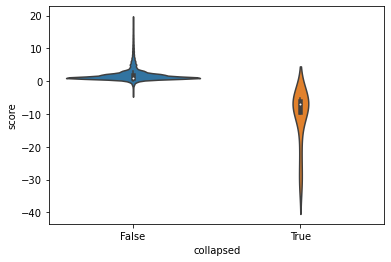

In [74]:
# Violin Plot of collapsed
sns.violinplot(x=df_viz["collapsed"], y=df_viz["score"])

Collapsed comments appear to often be negative comments, perhaps denoting an attempt by Reddit to hide negative comments.

<AxesSubplot:xlabel='no_follow', ylabel='score'>

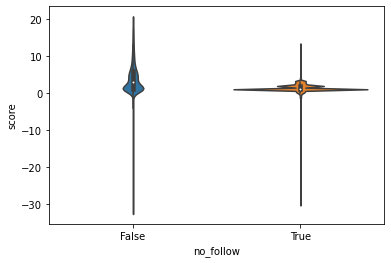

In [75]:
# Violin Plot of no_follow
sns.violinplot(x=df_viz["no_follow"], y=df_viz["score"])

Comments that are followed and not followed appear to have similar scores and distributions.

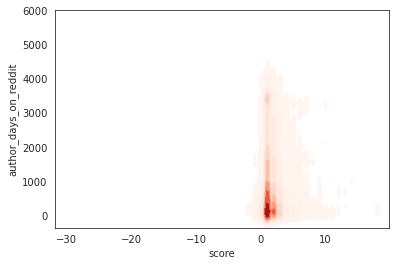

In [76]:
# Time on Reddit vs. Score 

# set seaborn style
sns.set_style("white")

# Custom the color, add shade and bandwidth
sns.kdeplot(x=df_viz["score"], y=df_viz["author_days_on_reddit"], 
            cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

Again, the vast majority of scores are at zero, which biases this. There appears to be no correlation here. 

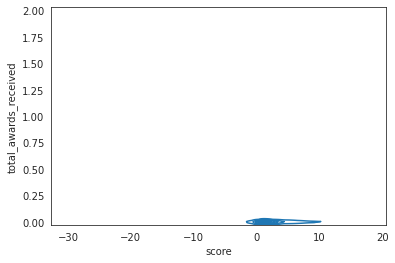

In [77]:
# Total Awards vs. Score 

# Custom the color, add shade and bandwidth
sns.kdeplot(x=df_viz["score"], y=df_viz["total_awards_received"])
plt.show()

This figure shows us that the vast majority of scores are near zero.

## 3. Models

In [78]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline, Model

### Question Being Explored

What determines an author's average comment score?

What determines a comment's average score?

### Select the Data

In [79]:
# Create a dataframe aggregated by author
df_author = df_full.groupby("author_fullname").agg(
    countDistinct('link_id').alias('num_unique_posts_commented_on'),
    count('id').alias('num_comments'),
    mean("score").alias('score'),
    mean("total_awards_received").alias('mean_awards_received_per_comment'),
    mean("comment_char_length").alias('mean_comment_length'),
    mean("author_days_on_reddit").alias('mean_days_on_reddit'),
    mean("controversiality").alias("proportion_controversial_comments"),
    mean(col("collapsed").cast("integer")).alias("proportion_comments_collapsed"),
    mean("gilded").alias("is_gilded"),
    mean(col("is_submitter").cast("integer")).alias("proportion_comments_on_own_posts"),
    mean(col("no_follow").cast("integer")).alias("proportion_comments_not_followed"),
    # f.max(f.struct(col('day_of_week'))).alias('most_common_day_of_week'),
    # f.max(f.struct(col('hour'))).alias('most_common_hour'),
    ).drop("author_fullname")

df_author.show(10)

+-----------------------------+------------+------------------+--------------------------------+-------------------+-------------------+---------------------------------+-----------------------------+--------------------+--------------------------------+--------------------------------+
|num_unique_posts_commented_on|num_comments|             score|mean_awards_received_per_comment|mean_comment_length|mean_days_on_reddit|proportion_controversial_comments|proportion_comments_collapsed|           is_gilded|proportion_comments_on_own_posts|proportion_comments_not_followed|
+-----------------------------+------------+------------------+--------------------------------+-------------------+-------------------+---------------------------------+-----------------------------+--------------------+--------------------------------+--------------------------------+
|                         2288|        2931|2.3418628454452404|            0.002047082906857...| 112.86421016717844| 1342.3253178811817|

In [80]:
# Subset main dataframe
cols = ["collapsed", "controversiality", 
        "gilded", "is_submitter",
        "no_follow", "score", "total_awards_received", "author_days_on_reddit",
        "comment_char_length", "day_of_week", "hour"]
df_comment = df_full.select(*cols)

Note that no categorical features will be used here that aren't already transformed into booleans, as these booleans capture most of the information we're interested in.

### Train-Test Splitting

In [81]:
# Split data into training and testing features
train_data_a, test_data_a, predict_data_a = df_author.randomSplit([0.8, 0.18, 0.02], 24)
train_data_c, test_data_c, predict_data_c = df_comment.randomSplit([0.8, 0.18, 0.02], 24)

### One-Hot Encoding

As none of the feature's we're using are categorical, we will not need to convert strings to numerics here.

### Vector Assembler

In [82]:
# Create a features vector
vectorAssembler_features_a = VectorAssembler(
    inputCols=  ["num_unique_posts_commented_on", "num_comments",
                "mean_awards_received_per_comment", "mean_comment_length", 
                "mean_days_on_reddit", "proportion_controversial_comments", 
                "proportion_comments_collapsed", "is_gilded", "proportion_comments_on_own_posts", 
                "proportion_comments_not_followed"], 
    outputCol="features")

vectorAssembler_features_c = VectorAssembler(
    inputCols=  ["collapsed", "controversiality", 
                 "gilded", "is_submitter",
                 "no_follow", "total_awards_received", "author_days_on_reddit",
                 "comment_char_length", "day_of_week", "hour"], 
    outputCol="features")

### Standard Scaling

In [83]:
# Standardize the scales of all features
standardScaler = StandardScaler(inputCol = "features",
                                outputCol = "scaled_features")

### Supervised Learning Model

A gradient boosted tree will be used here as it works well with low dimensionality datasets. This is because decision trees grow bigger the more features there are to split on. As we have only 12 features, this will work nicely.

In [84]:
# Initialize a gradient boosted trees regressor
gbt = GBTRegressor(featuresCol = "scaled_features", labelCol = "score")

In [85]:
# Create two simple ML pipeline of scalings, feature vectors, and models
pipeline_gbt_a = Pipeline(stages=[vectorAssembler_features_a, 
                                standardScaler,
                                gbt])

pipeline_gbt_c = Pipeline(stages=[vectorAssembler_features_c, 
                                standardScaler,
                                gbt])

In [86]:
# Train the models
model_gbt_a = pipeline_gbt_a.fit(train_data_a)
model_gbt_c = pipeline_gbt_c.fit(train_data_c)

In [87]:
# Save models
model_gbt_a.write().overwrite().save("s3://mar420-labdata/gbt_author_score_model")
model_gbt_c.write().overwrite().save("s3://mar420-labdata/gbt_comment_score_model")

### Performance Evaluation

Here we use root mean squared error to assess how successful this model has been.

In [88]:
# Transform the test data using our pipelines
predictions_a = model_gbt_a.transform(test_data_a)
predictions_c = model_gbt_c.transform(test_data_c)

In [89]:
# Evaluate our models using accuracy score
evaluatorRF = RegressionEvaluator(labelCol="score", metricName="rmse")
rmse_a = evaluatorRF.evaluate(predictions_a)
rmse_c = evaluatorRF.evaluate(predictions_c)

In [90]:
# Show the testing accuracy and error
print("RMSE (Authors) = %g" % rmse_a)
print("RMSE (Comments) = %g" % rmse_c)

RMSE (Authors) = 205.808
RMSE (Comments) = 323.842


## 4. Future Work

If I could continue this work into the future, I'd explore two different ideas. First, how do one's prior comments impact the score/awards of their current comments? For example, do people with longer, more engaged with comments in the past maintain and build on that engagement? Essentially, I'm curious in exploring further how one's engagement with a subreddit influences that subreddit's engagement with them.

Second, I'd like to run a sentiment analysis or topic model on the text of comments. That way, I could find out if negative or positive comments are more engaged with and whether certain topics are more popular.

# MAKE SURE YOU STOP YOUR EMR CLUSTER!

In [91]:
spark.stop()